# Milestone 2 EDA and Preprocessing
This dataset was obtained with permission from Yagya Raj Pandeya, who published a paper using CNNs to classify cat sounds as we aim to in this project(https://www.mdpi.com/2076-3417/8/10/1949#). The structure of the dataset is 10 folders, each titled with one of 10 classification labels('Angry', 'Defence', 'Fighting', 'Happy', 'HuntingMind', 'Mating', 'MotherCall', 'Paining', 'Resting', 'Warning') and containing mp3 files with audio recordings of cats making sounds corresponding to each class. The data was gathered from online sources eg Youtube. Thus our features are audio recordings, which will be preprocessed as prescribed below, and our response is a class label correpsonding to the mood of the cat. Given the nature of there being essentially one feature per observation, there is no missing data in our dataset.

As can be seen in our EDA below, our dataset is nearly perfectly balanced, with about 300 observations per class for a total of nearly 3,000 audio files. A large drawback of this is our small sample size in the context of training CNNs, which often require far more observations to obtain good results. To mitigate this we will perform data augmentation on our training set as described and performed below. Additionally, we will likely use transfer learning with weights from a CNN used to classify music, retraining the outermost layers for our classification task. There is precedent for this in the literature as seen in Pandeya's paper. 

Our preprocessing pipeline is as follows:
- Read in the mp3 files and their corresponding class labels
- Perform 80-20 train test split as we only want to augment train data. Since our dataset is balanced we need not worry about stratifying along ourput classes - on average we will have equal proportions of each in test and train. 
- Perform data augmentation on train set. Right now parameters are as follows:
  1. Time stretch between 0.9 and 1 (ie slightly slowing down recording)
  2. Shift pitch up or down 4 semitones
  3. Add slight Gaussian noise
  4. Shift recording 20% to the right or left
- We do not drastically augment the data in order to retain the original underlying structure that we hope to learn in our CNN. Right now we produce 3 augmented files per original recording in order to achieve a larger training set, but this parameter can be adjusted as we see fit
- After data augmentation we pad our recordings with zeros in order to achieve uniform input size. Right now we pad all samples, train and test, to the longest recording in the dataset, but there may be better ways to ensure uniform input lengths like segmenting the recordings. More on this below
- Finally, we convert our audio recordings into their mel spectrogram representations(https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html) using the fast fourier transform(FFT). This brings the recordings into the frequency domain and represents the samples as 2D arrays, with one axis representing time and one representing frequencies. This format is suitable for use as CNN inputs.

We feel that our largest issue is with the size of our dataset and are seeking feedback on appropriate levels of data augmentation(ie how many augmented samples per original sample is permissible). Furthermore since our input files can be of varying lengths, zero padding causes some of them to have very little signal. Although our CNN should be able to deal with this zero padding and learn local features of the data, we are considering segmenting our recordings into clips of more uniform length or using more advanced strategies like attention mechanisms to ensure that our CNN is learning from the audio features rather than the whitespace surrounding them. We are also open to feedback surrounding the parameters used for our data augmentation.

Below we perform these preprocessing steps and itertively visualize a subset of the data to get a feel for what it is these actions are doing. Another step we would like to take is to manually listen to a few of our augmented data files to ensure that they're taking the actions desired and are still recognizeable as cat sounds. 

In [1]:
import numpy as np
import pandas as pd
import librosa
import os
import numpy as np
from pydub import AudioSegment
from audiomentations import Compose, AddGaussianNoise, PitchShift, TimeStretch, Shift, ClippingDistortion
from sklearn.model_selection import train_test_split
import re
import io
import matplotlib.pyplot as plt
from collections import Counter

## Read in Data (mp3 -> np.array)

In [2]:
%%time
features = []
labels = []

path = 'data/'

# helper to throw out augmented files
def is_raw_mp3(file_name):
    return bool(re.search(r'\.mp3$', file_name) and not re.search(r'_aug1\(1\)\.mp3$', file_name))

# fix sampling rate at 16 kHz
sr = 16000

# reading in mp3 files and corresponding classes before train test split
for subdir, dirs, files in os.walk(path):
    for file in files:
        filepath = os.path.join(subdir, file)
        class_label = os.path.basename(subdir)
        if not is_raw_mp3(filepath):
            continue
        audio, _ = librosa.load(filepath, sr=sr)
        features.append(audio)
        labels.append(class_label)
        

Note: Illegal Audio-MPEG-Header 0xbf082800 at offset 7536.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


CPU times: user 21.6 s, sys: 1.32 s, total: 22.9 s
Wall time: 24.7 s


## Ensure dataset is balanced

In [3]:
label_counts = Counter(labels)

print('Label counts for entire dataset - we see that it is balanced')
formatted_string = '\n'.join([f"{label}: {count}" for label, count in label_counts.items()])
print(formatted_string)

Label counts for entire dataset - we see that it is balanced
Paining: 291
Defence: 291
Happy: 296
Mating: 301
Angry: 300
HuntingMind: 289
Fighting: 300
MotherCall: 296
Resting: 296


In [4]:
# Grab max length in set for zero padding later
target_len = np.max([len(file) for file in features])

## Train Test Split

In [5]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")

Training set size: 2368 samples
Testing set size: 592 samples


In [6]:
train_label_counts = Counter(y_train)
print('Label counts for train set:')
formatted_string = '\n'.join([f"{label}: {count}" for label, count in train_label_counts.items()])
print(formatted_string)

Label counts for train set:
Resting: 232
Defence: 221
Angry: 248
HuntingMind: 238
MotherCall: 233
Mating: 249
Happy: 240
Paining: 225
Fighting: 241


In [7]:
test_label_counts = Counter(y_test)

print('Label counts for test set:')
formatted_string = '\n'.join([f"{label}: {count}" for label, count in test_label_counts.items()])
print(formatted_string)

Label counts for test set:
HuntingMind: 51
Angry: 52
Happy: 56
Fighting: 59
MotherCall: 63
Defence: 70
Resting: 64
Paining: 66
Mating: 52


## Grab sample indices from each class for visual inspection


In [8]:
unique_classes = set(y_train)
sampled_indices = []
for cls in unique_classes:
    for idx, label in enumerate(y_train):
        if label == cls:
            sampled_indices.append(idx)
            break  

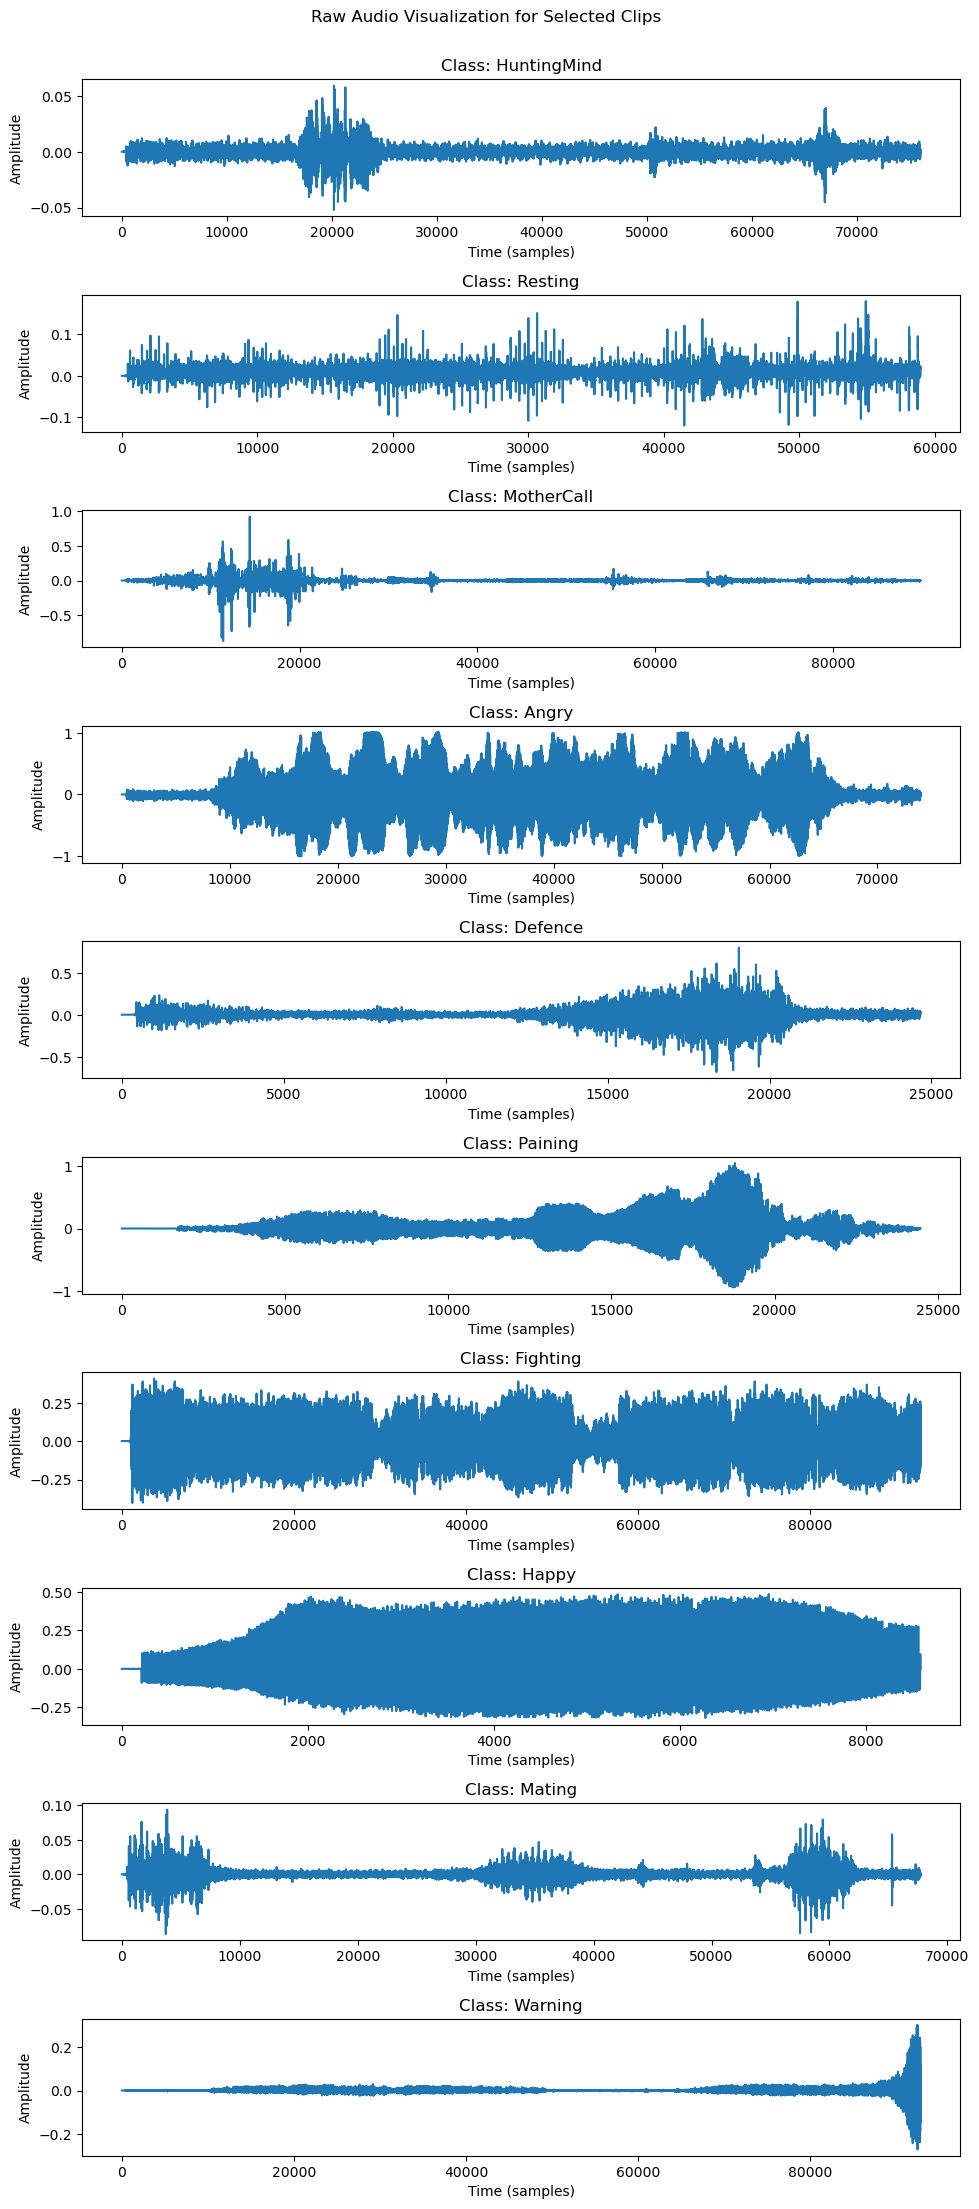

In [9]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 22))

plt.suptitle('Raw Audio Visualization for Selected Clips', y=1.002)

for i, idx in enumerate(sampled_indices):
    axes[i].plot(X_train[idx])
    axes[i].set_title(f'Class: {y_train[idx]}')
    axes[i].set_xlabel('Time (samples)')
    axes[i].set_ylabel('Amplitude')

# Adjust the layout
plt.tight_layout()
plt.show()

## Augment training data per specifications above

In [10]:
# Augmenter for training data
augmenter = Compose([
        # speed change between 0.9 and 1
        TimeStretch(min_rate=0.9, max_rate=1.0, p=0.5),
        # pitch shift between -4 and 4
        PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
        # gaussian noise
        AddGaussianNoise(min_amplitude=0.1, max_amplitude=0.5, p=0.5),
        # time shift within 20% of original clip
        Shift(min_shift=-0.2, max_shift=0.2, shift_unit='fraction', p=0.5),
    ])

In [11]:
%%time
# Augment training data to create additional samples

def augment_training(features, labels, n_augment, augmenter=augmenter):
    augment_features = []
    augment_labels = []
    for feature, label in zip(features, labels):
        for _ in range(n_augment):
            augment_features.append(augmenter(samples = feature, sample_rate = sr))
            augment_labels.append(label)
    features.extend(augment_features)
    labels.extend(augment_labels)
    return features, labels

X_train_aug, y_train_aug = augment_training(X_train, y_train, 3, augmenter)

print(f'X train now has {len(X_train_aug)} samples including augmented')

X train now has 9472 samples including augmented
CPU times: user 2min 2s, sys: 1.01 s, total: 2min 3s
Wall time: 2min 4s


## Zero padding

In [12]:
%%time
# function to pad to a single length, the maximum input length from the dataset
def pad(signals, target_length=target_len):
    padded = []
    for file in signals:
        cur_length = len(file)
        if cur_length == target_length:
            padded.append(file)
            continue
        total_padding = target_length - cur_length
        if total_padding < 0:
            # truncate if file is too long(this should never happen by construction)
            padded.append(file[:target_length])
            continue
        # handling parity
        pad_before = total_padding // 2
        pad_after = total_padding - pad_before
        padded_signal = np.pad(file, (pad_before, pad_after), mode='constant', constant_values=0)
        padded.append(padded_signal)
    return padded

X_train_padded = pad(X_train_aug)
X_test_padded = pad(X_test)

CPU times: user 657 ms, sys: 2.71 s, total: 3.36 s
Wall time: 10.3 s


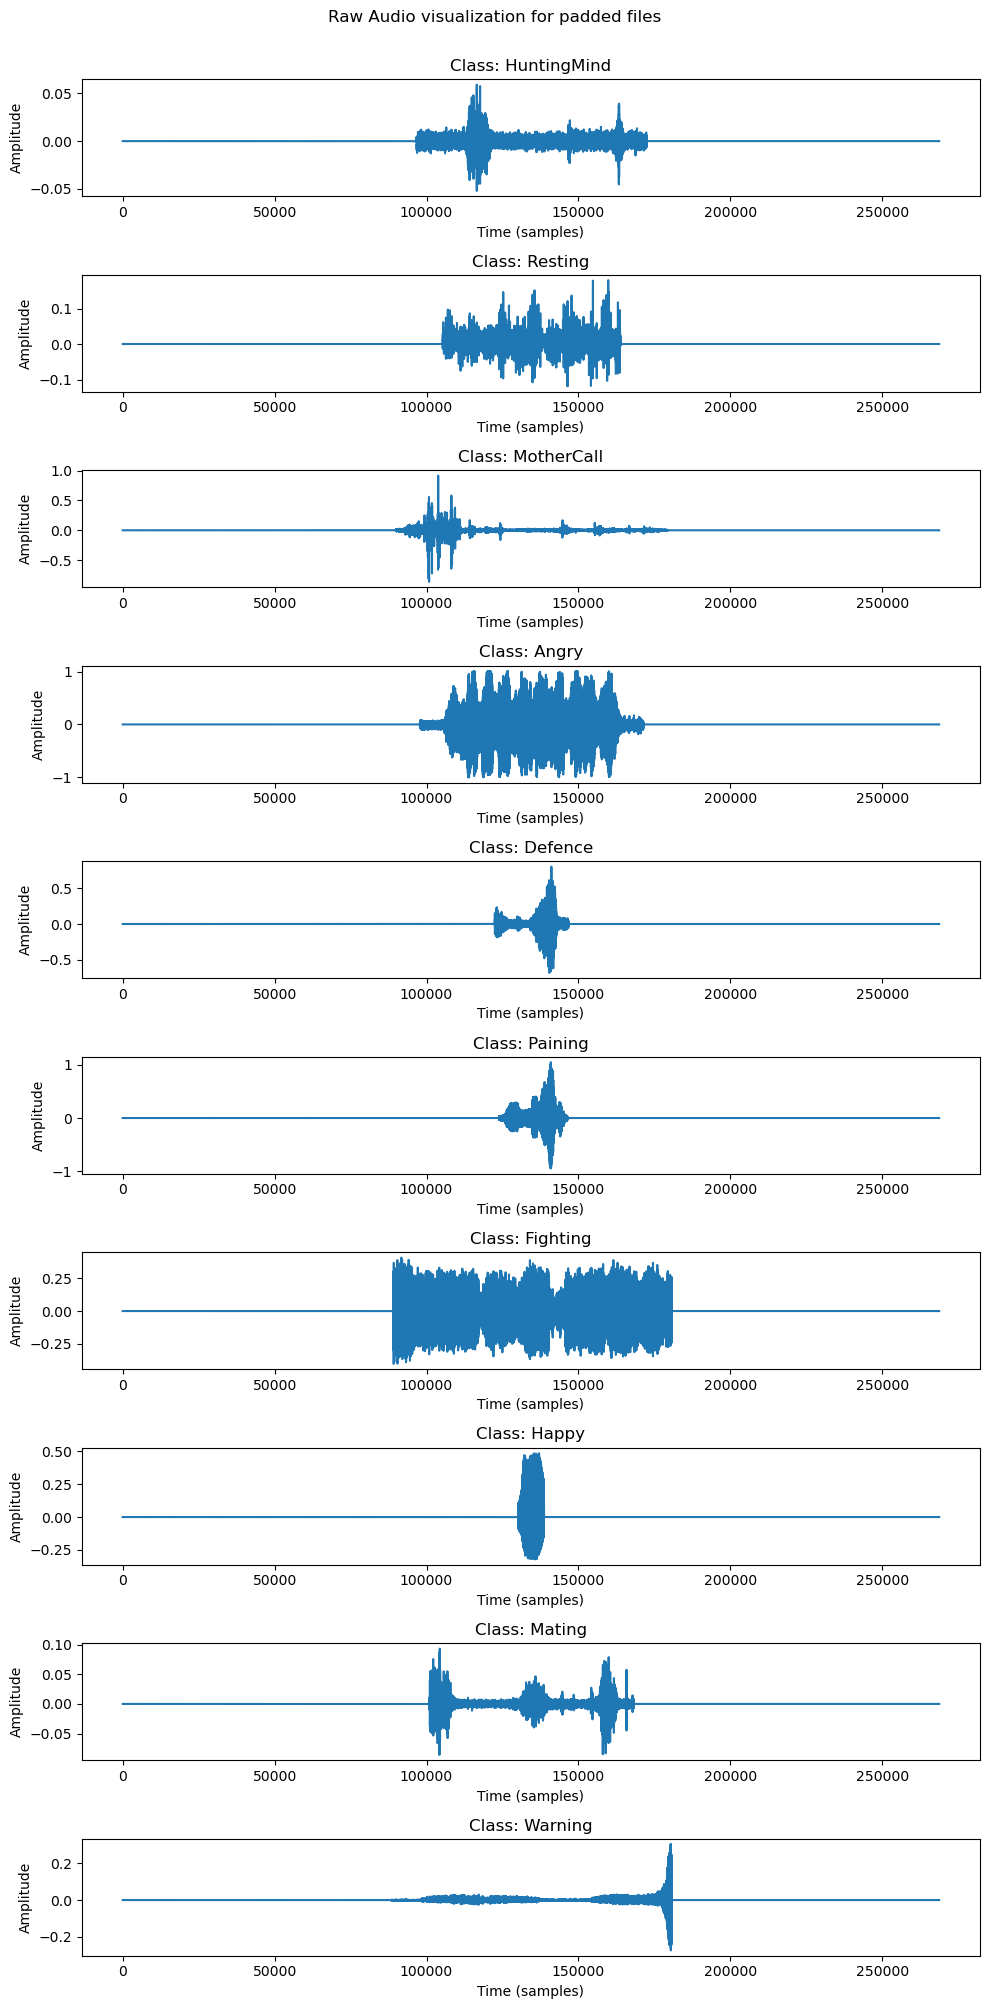

In [13]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 20))

plt.suptitle('Raw Audio visualization for padded files', y = 1.002)

for i, idx in enumerate(sampled_indices):
    axes[i].plot(X_train_padded[idx])
    axes[i].set_title(f'Class: {y_train_aug[idx]}')
    axes[i].set_xlabel('Time (samples)')
    axes[i].set_ylabel('Amplitude')

# Adjust the layout
plt.tight_layout()
plt.show()

## Convert to Mel Spectrogram

In [14]:
%%time
def convert_to_mel(audio_signals, sample_rate=sr, n_mels=96, n_fft=2048, hop_length=256):
    mel_spectrograms = []
    for signal in audio_signals:
        # Compute the mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
        # Convert to decibels
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        # Append to the list
        mel_spectrograms.append(mel_spec_db)
    return mel_spectrograms

X_train = convert_to_mel(X_train_padded)
X_test = convert_to_mel(X_test_padded)


CPU times: user 6min 26s, sys: 13.9 s, total: 6min 39s
Wall time: 3min 54s


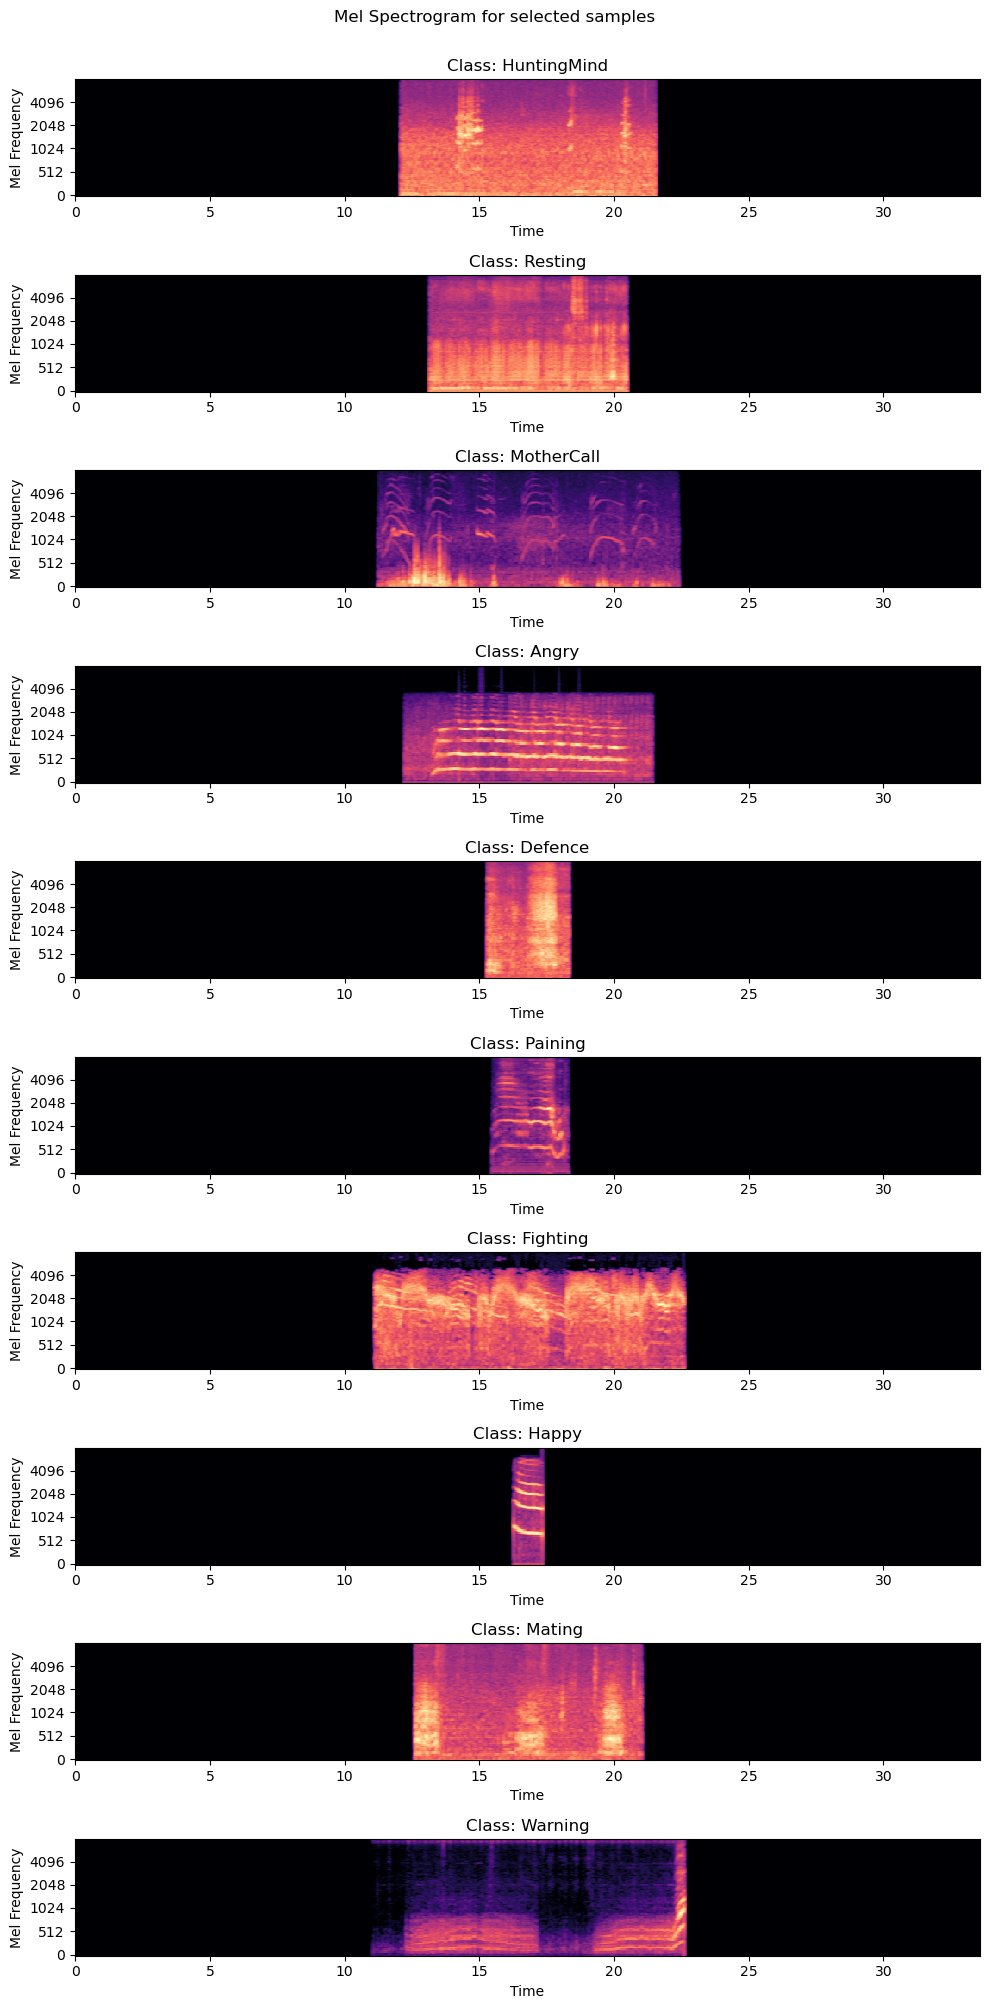

In [16]:
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(10, 20))
axes.flatten()
plt.suptitle('Mel Spectrogram for selected samples', y = 1.002)
# Plot each mel spectrogram and set the title
for i, idx in enumerate(sampled_indices):
    librosa.display.specshow(X_train[idx], ax=axes[i], sr=16000, x_axis='time', y_axis='mel', hop_length=512)
    axes[i].set_title(f'Class: {y_train[idx]}')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Mel Frequency')

# Adjust the layout
plt.tight_layout()
plt.show()